# Cifar-100 Dataset
#### The Cifar-100 dataset consists of 60,000 32x32 color images in 100 classes with 600 images per class.
Dataset Reference: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009
URL: http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

In this notebook several configurations of the dataset are used to do image classification with Convolutional Neural Networks (CNN).

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
# import tensorflow as tf
import numpy as np
import os
import pickle
import config
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
with open(os.path.join(config.dataset_dir, "cifar100\\train"), 'rb') as train_data:
    train_dict = pickle.load(train_data, encoding='bytes')
with open(os.path.join(config.dataset_dir, "cifar100\\test"), 'rb') as test_data:
    test_dict = pickle.load(test_data, encoding='bytes')
with open(os.path.join(config.dataset_dir, "cifar100\\meta"), 'rb') as label_names:
    name_dict = pickle.load(label_names, encoding='bytes')
print(train_dict.keys())
print(name_dict.keys())

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
dict_keys([b'fine_label_names', b'coarse_label_names'])


### Data Preprocessing
The images are encoded as RGB. Each array in the train- and test-dict consists of 3072 values that need to be reshaped in order to be readable. This also required for the CNN to learn image related features like edges and contrasts. The name-dict contains the full-names of all labels while the train- and test-dict have just the index numbers of these full-names.

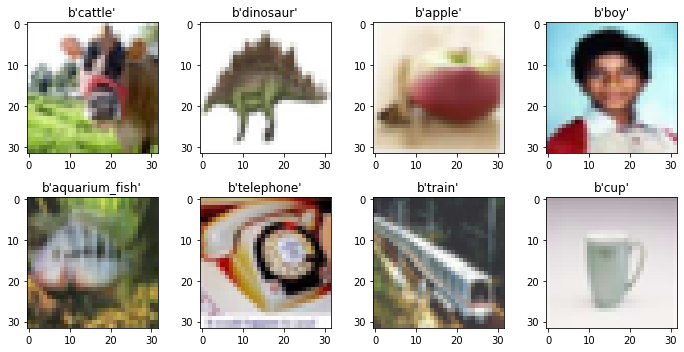

In [4]:
labels = name_dict[b'fine_label_names']

fig = plt.figure(figsize=(10, 5))
for h in range(8):
    plt.tight_layout()
    data = train_dict[b'data'][h]
    img = []
    for i in range(1024):
        rgb = [data[i], data[i + 1024], data[i + 2 * 1024]]
        img.append(rgb)
    img = np.asarray(img)
    img = img.reshape(32, 32, 3)
    ax = fig.add_subplot(2, 4, h+1)
    ax.imshow(img)
    plt.title(labels[int(train_dict[b'fine_labels'][h])])




All necessary preprocessing operations, meaning data scaling, shuffeling and reshaping are wrapped into the preprocessing function. Also essential for the classification is the label convertation to a one-hot-vector. 

In [ ]:
def preprocessing(examples, labels):
    examples = examples / 255
    one_hot = np.eye(100)
    
    number_of_examples = len(examples)
    shuffle_indices = np.arange(number_of_examples)
    random.shuffle(shuffle_indices)
    
    shuffled_x = np.empty([number_of_examples, 32, 32, 3])
    shuffled_y = np.empty([number_of_examples, 100])
    for i in tqdm(range(number_of_examples)):
        
        img = np.empty([1024, 3])
        for j in range(1024):
            rgb = [examples[i, j], examples[i, j + 1024], examples[i, j + 2 * 1024]]
            img[j] = rgb
            
        shuffled_x[shuffle_indices[i]] = img.reshape(32, 32, 3)
        shuffled_y[shuffle_indices[i]] = one_hot[int(labels[i])]
                  
        
        
    return shuffled_x, shuffled_y

    
tr_x, tr_y = preprocessing(train_dict[b'data'], train_dict[b'fine_labels'])
te_x, te_y = preprocessing(test_dict[b'data'], test_dict[b'fine_labels'])

train_file = open(os.path.join(config.dataset_dir, 'cifar100\\train_dataset'), 'wb')
test_file = open(os.path.join(config.dataset_dir, 'cifar100\\test_dataset'), 'wb')
pickle.dump([tr_x, tr_y], train_file)
pickle.dump([te_x, te_y], test_file)
train_file.close()
test_file.close()

In [3]:
with open(os.path.join(config.dataset_dir, "cifar100\\train_dataset"), 'rb') as train_data:
    tr = pickle.load(train_data, encoding='bytes')
with open(os.path.join(config.dataset_dir, "cifar100\\test_dataset"), 'rb') as test_data:
    te = pickle.load(test_data, encoding='bytes')

In [9]:
print(tr[0].shape)

(50000, 32, 32, 3)


### Model Building

In [13]:
train_dataset = np.expand_dims(tr[0], axis=5)
test_dataset = np.expand_dims(te[0], axis=5)

train_dataset = tf.data.Dataset.from_tensor_slices((tr[0], tr[1]))
train_dataset = train_dataset.batch(100)


# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(32, 32, 3, 1)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(100, activation='softmax')
# ])

model = tf.keras.Sequential([
 tf.keras.layers.Conv2D(6, [5, 5], 1, activation="elu", input_shape=(32, 32, 3)),
 tf.keras.layers.MaxPool2D([2, 2], 2),
 tf.keras.layers.Conv2D(16, [5, 5], 1, activation="elu"),
 tf.keras.layers.MaxPool2D([2, 2], 2),
 tf.keras.layers.Conv2D(120, [5, 5], 1, activation="elu"),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(100, activation="softmax")
])
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_dataset, epochs=10)


c:\users\cedric\pycharmprojects\basicmachinelearning\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.
c:\users\cedric\pycharmprojects\basicmachinelearning\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_3 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)              

W0714 13:18:56.864595  7752 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/10


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [100,100] and labels shape [10000]
	 [[node loss_3/dense_3_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-13-d0c91d3b3f61>:25) ]] [Op:__inference_keras_scratch_graph_2994]

Function call stack:
keras_scratch_graph


In [3]:
Liste = [10, 6, 3, 7, 9, 2, 6, 5]

i = 0
while i < len(Liste):
    for j in range(len(Liste)-i-1):
        if Liste[j] > Liste[j+1]:
            x = Liste[j+1]
            Liste[j+1] = Liste[j]
            Liste[j] = x
            print(Liste)
    i += 1
print(Liste)


[6, 10, 3, 7, 9, 2, 6, 5]
[6, 3, 10, 7, 9, 2, 6, 5]
[6, 3, 7, 10, 9, 2, 6, 5]
[6, 3, 7, 9, 10, 2, 6, 5]
[6, 3, 7, 9, 2, 10, 6, 5]
[6, 3, 7, 9, 2, 6, 10, 5]
[6, 3, 7, 9, 2, 6, 5, 10]
[3, 6, 7, 9, 2, 6, 5, 10]
[3, 6, 7, 2, 9, 6, 5, 10]
[3, 6, 7, 2, 6, 9, 5, 10]
[3, 6, 7, 2, 6, 5, 9, 10]
[3, 6, 2, 7, 6, 5, 9, 10]
[3, 6, 2, 6, 7, 5, 9, 10]
[3, 6, 2, 6, 5, 7, 9, 10]
[3, 2, 6, 6, 5, 7, 9, 10]
[3, 2, 6, 5, 6, 7, 9, 10]
[2, 3, 6, 5, 6, 7, 9, 10]
[2, 3, 5, 6, 6, 7, 9, 10]
[2, 3, 5, 6, 6, 7, 9, 10]


In [1]:
def kapitalwert(I, T, Z, i, L):
    sum = 0
    t = 1
    
    while t < T:
        if 1<t<4:
            Z *= 1.5
        sum += Z/((1+i)**t)
        t+=1
        print(t)
    
    C= -I + sum + L*((1+i)**(-T))
    return C

C = kapitalwert(1, 2, 3, 4, 5)
print(C)
        

2
-0.2
